## Displaying combined plots of histograms and spectra m/z intensitiy

To do a better comparison filter aand unfilter spectra was compare in one plot, this was made for the similarity score histograms and the m/z inteisities plot

## Obtaining the data from the Mona File

## Getting the path for Mona file

Using the method load_from_msp, the information inside the Mona file is being obtained.

In [1]:
import os
import sys

ROOT = os.path.dirname(os.getcwd())
sys.path.insert(0, ROOT)

In [2]:
from custom_functions.spectra_functions import get_data_folder_path

# from_external=False to use the data folder within the project
path = get_data_folder_path(from_external=False)
spectrums_file = os.path.join(path, "MoNA-export-GC-MS.msp")

## Only Normalizing intensities

In [3]:
from matchms.filtering import normalize_intensities
from matchms.filtering import reduce_to_number_of_peaks
from matchms.filtering import select_by_mz
from matchms.filtering import require_minimum_number_of_peaks
from matchms.importing import load_from_msp
import numpy as np


def apply_my_filters(s):
    s = normalize_intensities(s)
    s = reduce_to_number_of_peaks(s, n_required=10, ratio_desired=0.5)
    s = select_by_mz(s, mz_from=0, mz_to=1000)
    s = require_minimum_number_of_peaks(s, n_required=10)
    return s

spectrums = [s for s in load_from_msp(spectrums_file)]

spectrums_unfiltered = [normalize_intensities(s) for s in spectrums]
spectrums_filtered = [apply_my_filters(s) for s in spectrums]

spectrums_unfiltered = [s for s in spectrums_unfiltered if s is not None]
spectrums_filtered = [s for s in spectrums_filtered if s is not None]

## Grouping spectra by same and different molecules

Using the methods **separate_by_same_inchikey** and **separate_by_diff_inchikey**, the spectra is being separated in groups of groupes of spectra that are from the same and different molecule.

In [4]:
from custom_functions.spectra_functions import grouped_by_same_mol
from custom_functions.spectra_functions import grouped_by_diff_mol

Then obtaining one thousand samples in pairs of 2 spectra from the same molecule and 1 thousand pairs from different molecule

In [5]:

group_spectra_same_molecule_unfiltered = grouped_by_same_mol(spectrums_unfiltered, 1000)
group_spectra_same_molecule_filtered = grouped_by_same_mol(spectrums_filtered, 1000)

group_spectra_diff_molecule_unfiltered = grouped_by_diff_mol(spectrums_unfiltered, 1000)
group_spectra_diff_molecule_filtered = grouped_by_diff_mol(spectrums_filtered, 1000)


9006 unique inchikeys
8843 unique inchikeys
9006 unique inchikeys
8843 unique inchikeys


# Computing the Cosine Similarity

## Defining the method to compute the similarity scores

This method will have a **default tolerance of 0.1**, it will return an numpy array with the reference spectra, query spectra, the score and matched peaks.

In [6]:
from matchms import calculate_scores
from matchms.similarity import CosineGreedy
import numpy as np

def calculate_similarity_scores(group_spectra, tolerance=0.1, show_data = False):
    scores_hist = []
    for k, spectrums in enumerate(group_spectra):
        
        scores = calculate_scores(references=spectrums,
                                queries=spectrums,
                                similarity_function=CosineGreedy(tolerance))
        
        for k, score in enumerate(scores):
            if k == 1:
                (reference, query, score, n_matching) = score
                
                scores_hist.append({'reference':reference, 'query':query, 'score':score, 'n_matching':n_matching})
                
                if show_data:
                    print(f"Reference scan name: {reference.metadata['name']} - Query scan name: {query.metadata['name']}")
                    print(f"Reference InChiKey: {reference.metadata['inchikey']} - Query InChiKey: {query.metadata['inchikey']}")
                    print(f"Score: {score:.4f}")
                    print(f"Number of matching peaks: {n_matching}")
                    print("----------------------------")

    return np.array(scores_hist)

## Computing the similarities of spectra with same and diff molecule

In this case the **tolerance 0.25 and 0.5**

In [7]:
tolerances = [0.25, 0.5]
similarity_same_molecule_unfiltered, similarity_same_molecule_filtered = [], []
similarity_diff_molecule_unfiltered, similarity_diff_molecule_filtered = [], []


for t in tolerances:
    similarity_same_molecule_unfiltered.append(calculate_similarity_scores(group_spectra_same_molecule_unfiltered, t))
    similarity_same_molecule_filtered.append(calculate_similarity_scores(group_spectra_same_molecule_filtered, t))
    similarity_diff_molecule_unfiltered.append(calculate_similarity_scores(group_spectra_diff_molecule_unfiltered, t))
    similarity_diff_molecule_filtered.append(calculate_similarity_scores(group_spectra_diff_molecule_filtered, t))


# Plotting histograms of the obtained scores

The following histrograms show those of the same and different molecules.

It was observed that the difference in score with different tolerances did not made much difference, so the similarity calculations only the data with 0.5 of tolerance was used

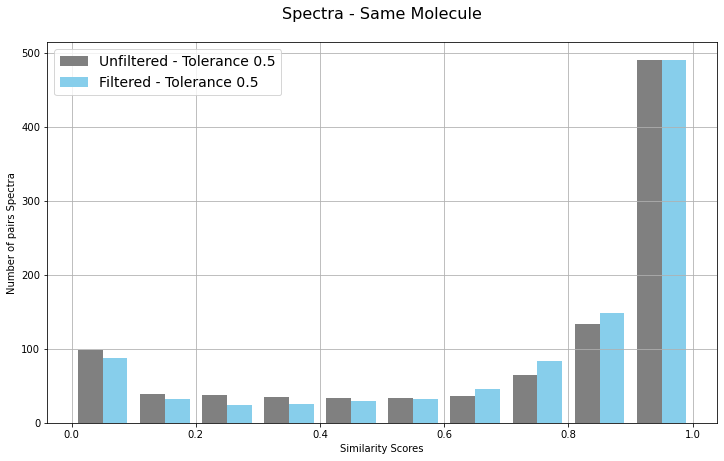

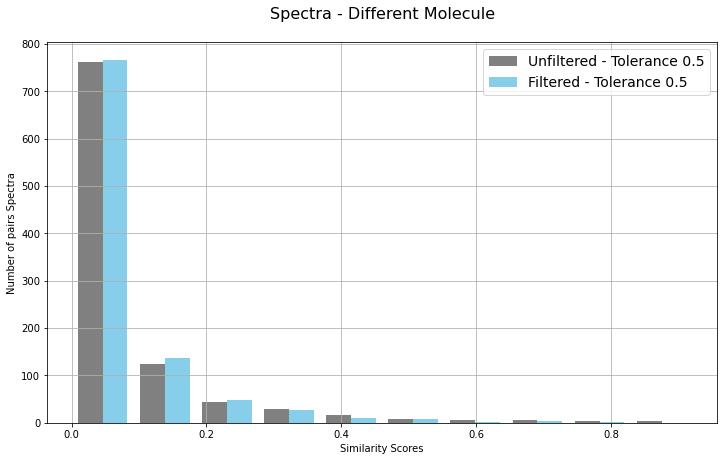

In [8]:
import matplotlib.pyplot as plt

scores_same_molecule_unfiltered_tol025 = [g['score'] for g in similarity_same_molecule_unfiltered[0]]
scores_same_molecule_unfiltered_tol05 = [g['score'] for g in similarity_same_molecule_unfiltered[1]]
scores_same_molecule_filtered_tol025 = [g['score'] for g in similarity_same_molecule_filtered[0]]
scores_same_molecule_filtered_tol05 = [g['score'] for g in similarity_same_molecule_filtered[1]]

scores_diff_molecule_unfiltered_tol025 = [g['score'] for g in similarity_diff_molecule_unfiltered[0]]
scores_diff_molecule_unfiltered_tol05 = [g['score'] for g in similarity_diff_molecule_unfiltered[1]]
scores_diff_molecule_filtered_tol025 = [g['score'] for g in similarity_diff_molecule_filtered[0]]
scores_diff_molecule_filtered_tol05 = [g['score'] for g in similarity_diff_molecule_filtered[1]]

scores_same_mol = [scores_same_molecule_unfiltered_tol05, scores_same_molecule_filtered_tol05]
scores_diff_mol = [scores_diff_molecule_unfiltered_tol05, scores_diff_molecule_filtered_tol05]

def print_histogram(data, title=None, legend_loc="upper right"):
    
    plt.figure(figsize=(12,7))
    
    labels = ["Unfiltered - Tolerance 0.5", "Filtered - Tolerance 0.5"]
    plt.hist(data, color=["gray", "skyblue"], label=labels)
    plt.legend(loc=legend_loc, fontsize=14)

    plt.grid(True)
    if title is not None:
        plt.title(title, fontsize=16)
    plt.xlabel("Similarity Scores")
    plt.ylabel("Number of pairs Spectra")
    plt.show()

print_histogram(scores_same_mol, "Spectra - Same Molecule\n", "upper left")
print_histogram(scores_diff_mol, "Spectra - Different Molecule\n", "upper right")

## Function for a mirror plot of spectra m/z and intensities

In [9]:
def print_mirror_plot(unfiltered, filtered):

    fig, [ax1, ax2] = plt.subplots(2,1, sharex=True, figsize=(12,7))

    unfiltered_spectrum1, unfiltered_spectrum2 = unfiltered['reference'], unfiltered['query']
    filtered_spectrum1, filtered_spectrum2 = filtered['reference'], filtered['query']

    fig.text(0.5, 0.04, 'm/z', ha='center', fontsize=16)
    fig.text(0.04, 0.5, 'Intensities', va='center', rotation='vertical', fontsize=16)
        
    plt.subplots_adjust(hspace=0.0)
    ax1.grid(True)
    ax2.grid(True)

    for mz,intensity in zip(unfiltered_spectrum1.peaks.mz, unfiltered_spectrum1.peaks.intensities):
        ax1.plot([mz,mz],[0,intensity], color='gray', label='Unfiltered')

    for mz,intensity in zip(unfiltered_spectrum2.peaks.mz, unfiltered_spectrum2.peaks.intensities):
        ax2.plot([mz,mz],[0,intensity], color='gray', label='Unfiltered')

    for mz,intensity in zip(filtered_spectrum1.peaks.mz, filtered_spectrum1.peaks.intensities):
        ax1.plot([mz,mz],[0,intensity], color='skyblue', label='Filtered')

    for mz,intensity in zip(filtered_spectrum2.peaks.mz, filtered_spectrum2.peaks.intensities):
        ax2.plot([mz,mz],[0,intensity], color='skyblue', label='Filtered')

    ax2.set_ylim(ax2.get_ylim()[::-1])

    lines = ax1.get_lines()
    
    legends = ("Unfiltered - Score {:f}".format(unfiltered["score"]), "Filtered - Score {:f}".format(filtered["score"]))

    fig.legend((lines[0],lines[len(unfiltered_spectrum1.peaks.mz)+1]), legends, loc='upper right', fontsize=15)

    plt.show()
    

## Filtering Spectra by cosine score less than 0.1

In [10]:
scores_same_molecule_unfiltered_tol05 = np.array(scores_same_molecule_unfiltered_tol05)
scores_same_molecule_filtered_tol05 = np.array(scores_same_molecule_filtered_tol05)

idx = np.where(scores_same_molecule_unfiltered_tol05 < 0.1)
unfiltered_sample = np.random.choice(similarity_same_molecule_unfiltered[0][idx], 1)[0]

idx = np.where(scores_same_molecule_filtered_tol05 < 0.1)
filtered_sample = np.random.choice(similarity_same_molecule_filtered[0][idx], 1)[0]

Spectra Same Molecule score less than 0.1

Unfiltered Spectra
Top - Name: 3-(4-HYDROXY-3,5-DIMETHOXYPHENYL)-2-PROPENOIC ACID inchikey: PCMORTLOPMLEFB
Bottom - Name: Sinapic acid inchikey: PCMORTLOPMLEFB

Filtered Spectra
Top - Name: L-Citrulline inchikey: RHGKLRLOHDJJDR
Bottom - Name: Citrulline inchikey: RHGKLRLOHDJJDR


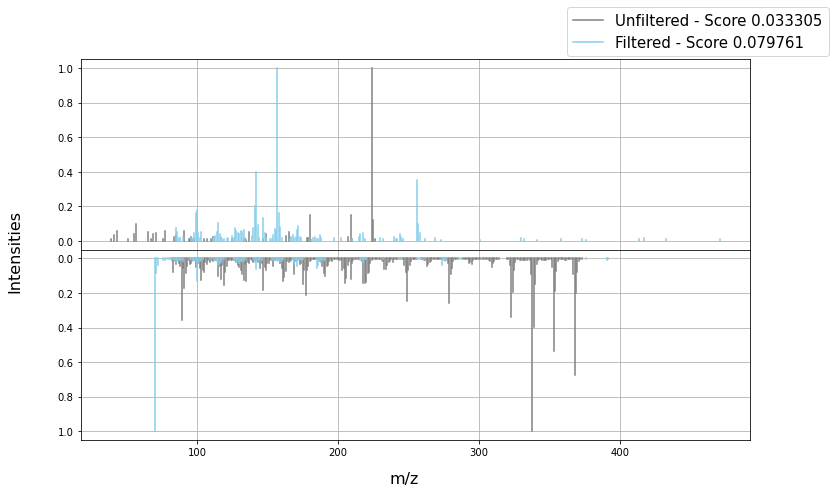

In [11]:
print("Spectra Same Molecule score less than 0.1")
print("\nUnfiltered Spectra")
print("Top - Name:", unfiltered_sample['reference'].get('name'), "inchikey:", unfiltered_sample['reference'].get('inchikey')[:14])
print("Bottom - Name:", unfiltered_sample['query'].get('name'), "inchikey:", unfiltered_sample['query'].get('inchikey')[:14])
print("\nFiltered Spectra")
print("Top - Name:", filtered_sample['reference'].get('name'), "inchikey:", filtered_sample['reference'].get('inchikey')[:14])
print("Bottom - Name:", filtered_sample['query'].get('name'), "inchikey:", filtered_sample['query'].get('inchikey')[:14])
print_mirror_plot(unfiltered_sample, filtered_sample)

# Filtering Spectra by cosine score higher than 0.9

Spectra of the same molecule now will be filtered by ones with a cosine score higher than 0.9.

In [12]:
idx = np.where(scores_same_molecule_unfiltered_tol05 > 0.9)
unfiltered_sample = np.random.choice(similarity_same_molecule_unfiltered[0][idx], 1)[0]

idx = np.where(scores_same_molecule_filtered_tol05 > 0.9)
filtered_sample = np.random.choice(similarity_same_molecule_filtered[0][idx], 1)[0]

Spectra Same Molecule score higher than 0.9

Unfiltered Spectra
Top - Name: 1,6-DIMETHYL-3,4-(5'-CHLORO)BENZO-2-OXABICYCLO(4.1.0)HEPT-3-EN-5-ONE inchikey: JCJUWMGJSYDXDU
Bottom - Name: 1,6-DIMETHYL-3,4-(5'-CHLOROBENZO)-2-OXABICYCLO(4.1.0)HEPT-3-EN-5-ONE inchikey: JCJUWMGJSYDXDU

Filtered Spectra
Top - Name: Tryptophanol inchikey: MBBOMCVGYCRMEA
Bottom - Name: tryptophol inchikey: MBBOMCVGYCRMEA


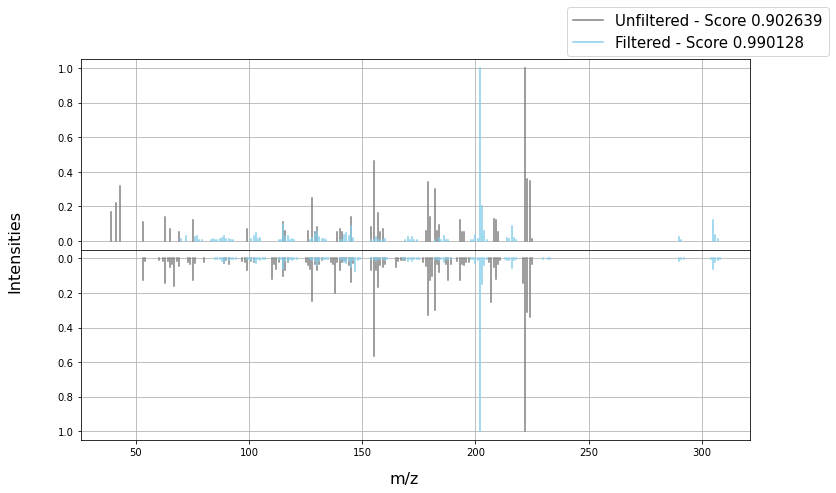

In [13]:
print("Spectra Same Molecule score higher than 0.9")
print("\nUnfiltered Spectra")
print("Top - Name:", unfiltered_sample['reference'].get('name'), "inchikey:", unfiltered_sample['reference'].get('inchikey')[:14])
print("Bottom - Name:", unfiltered_sample['query'].get('name'), "inchikey:", unfiltered_sample['query'].get('inchikey')[:14])
print("\nFiltered Spectra")
print("Top - Name:", filtered_sample['reference'].get('name'), "inchikey:", filtered_sample['reference'].get('inchikey')[:14])
print("Bottom - Name:", filtered_sample['query'].get('name'), "inchikey:", filtered_sample['query'].get('inchikey')[:14])
print_mirror_plot(unfiltered_sample, filtered_sample)